# **General func**

In [ ]:
VER = '0630-final'
CV = False

In [ ]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, re, time, warnings, pickle, psutil, random
from datetime import datetime, timedelta
from multiprocessing import Pool        # Multiprocess Runs
from math import ceil
import lightgbm as lgb
from typing import Union
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)                                      # float16 sucks
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
# GIT from discussion thread
import math, decimal
dec = decimal.Decimal

def get_moon_phase(d):  # 0=new, 4=full; 4 days/phase
    diff = d - datetime(2001, 1, 1)
    days = dec(diff.days) + (dec(diff.seconds) / dec(86400))
    lunations = dec("0.20439731") + (days * dec("0.03386319269"))
    phase_index = math.floor((lunations % dec(1) * dec(8)) + dec('0.5'))
    return int(phase_index) & 7

In [ ]:
PRICE_DTYPES = {
    "store_id": "category", 
    "item_id": "category", 
    "wm_yr_wk": "int16",
    "sell_price":"float32"
}

CAL_DTYPES={
        "event_name_1": "category", "event_name_2": "category", "event_type_1": "category", "event_type_2": "category", 
        "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int8", "month": "int8", "year": "int16", 
        "snap_CA": "int8", 'snap_TX': 'int8', 'snap_WI': 'int8'
}

In [ ]:
# BASE_PATH = './m5-forecasting-accuracy/'
BASE_PATH = './data/'

In [ ]:
def create_dt(is_train=True, is_cv=False, first_day=1, max_lags=120, tr_last=1941, nrows=None):
    """
    Create dataframe for training and predicting.
    Args:
        is_train: bool. If True, set start_day by first_day; Or set start_day 
                    by max_lags days before trn_last(enough historical sales features for lag&rolling)
        is_cv: bool. If True, don't drop zeros sales before release dates of items for alignment in CV.
        first_day: int. Only use data after this date.
        max_lag: int. This param interacts with lag&rolling features. Set max_lag=horizon+lags.max+wins.max.
        tr_last: int. Last date number of train set.
        nrows: int. Param in pd.read_csv.
    """
    prices = pd.read_csv(BASE_PATH + "sell_prices.csv", dtype=PRICE_DTYPES)            
    release_df = prices.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
    release_df.columns = ['store_id', 'item_id', 'release']
    
    cal = pd.read_csv(BASE_PATH + "calendar.csv", dtype=CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    cal['moon'] = cal.date.apply(get_moon_phase).astype('int8')
    
    start_day = max(1 if is_train else tr_last - max_lags, first_day)
    # slice data of interest
    numcols = [f"d_{day}" for day in range(start_day, tr_last + 1)]
    catcols = ['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(BASE_PATH + "sales_train_evaluation.csv", 
                     nrows=nrows, usecols=catcols+numcols, dtype=dtype)
    
    # prepare for test
    if not is_train:
        for day in range(tr_last + 1, tr_last + 28 + 1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                id_vars = catcols,
                value_vars = [col for col in dt.columns if col.startswith("d_")],
                var_name = "d",
                value_name = "sales")
    
    dt = dt.merge(cal, on="d")
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], how='left')
    dt = dt.merge(release_df, on=['store_id', 'item_id'], how='left')
    
    # remove leading zeros（added 2020.06.09 14:00 pm）
    # this may lead to shape unmatch during cv on folds 
    if not is_cv:
        dt = dt[dt['wm_yr_wk'] >= dt['release']]
        # solve price issue
    
    # SNAP 3 to 1（added 2020.06.09 12:00 pm）
    dt['is_snap'] = dt['snap_CA']
    dt.loc[dt.state_id == 'TX', 'is_snap'] = dt.loc[dt.state_id == 'TX', 'snap_TX']
    dt.loc[dt.state_id == 'WI', 'is_snap'] = dt.loc[dt.state_id == 'WI', 'snap_WI']
    del dt['snap_CA'], dt['snap_WI'], dt['snap_TX']
            
    dt['d'] = dt['d'].apply(lambda x: int(x.split('_')[-1])).astype('int16')
    
#     # log transform on target
#     dt['sales'] = np.log1p(dt['sales'])
    return dt

In [ ]:
def create_feat(dt):
    # label encoding
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category" and col != 'item_id':
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    for col in ['dept_id', 'cat_id', 'state_id']:
        dt[col] = dt[col].cat.codes.astype("int16")
        dt[col] -= dt[col].min()
        
    # date-related features
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")
            
    dt['year'] = (dt['year'] - 2011).astype("int8")
    # weekend
    dt['is_weekend'] = (dt['weekday'] >= 5).astype("int8")
    # days since release
    dt['d_from_release'] = (dt['wm_yr_wk'] - dt['release']).astype('int16')
    
    # price feature
    dt['price_max'] = dt.groupby(['store_id','item_id'])['sell_price'].transform('max').astype('float32')
    dt['price_min'] = dt.groupby(['store_id','item_id'])['sell_price'].transform('min').astype('float32')
    dt['price_std'] = dt.groupby(['store_id','item_id'])['sell_price'].transform('std').astype('float32')
    dt['price_mean'] = dt.groupby(['store_id','item_id'])['sell_price'].transform('mean').astype('float32')
    dt['price_norm'] = dt['sell_price'] / (dt['price_max'] + 1e-10).astype('float32')
    dt['price_nunique'] = dt.groupby(['store_id','item_id'])['sell_price'].transform('nunique').astype('int16')
    # more price changes features(TODO)
    dt['price_momentum_m'] = dt['sell_price']/dt.groupby(['store_id','item_id','month'])['sell_price'].transform('mean').astype('float32')
    
    # target encoding(more TODO)
    icols = [
        ['item_id', 'store_id'],
        ['item_id', 'state_id'],
        ['state_id', 'cat_id'],
        ['state_id', 'dept_id'],
        ['store_id', 'cat_id'],
        ['store_id', 'dept_id'],
    ]
    for col in icols:
        col_name = '_'+'_'.join(col)+'_'
        dt['enc'+col_name+'mean'] = dt.groupby(col)['sales'].transform('mean').astype('float32')
        dt['enc'+col_name+'std'] = dt.groupby(col)['sales'].transform('std').astype('float32')
        
    # last sale to current(TODO)
        
    # avoid lgbm memory spike
    dt['dept_id'] = dt['dept_id'].astype('int8')
    dt['store_id'] = dt['store_id'].astype('int8')       
    dt['cat_id'] = dt['cat_id'].astype('int8')    
    dt['state_id'] = dt['state_id'].astype('int8')        
    dt['weekday'] = dt['weekday'].astype('int8')       
    dt['wday'] = dt['wday'].astype('int8')           
    dt['month'] = dt['month'].astype('int8')          
    dt['event_name_1'] = dt['event_name_1'].astype('int8')   
    dt['event_type_1'] = dt['event_type_1'].astype('int8') 
    dt['event_name_2'] = dt['event_name_2'].astype('int8')   
    dt['event_type_2'] = dt['event_type_2'].astype('int8') 
    dt['release'] = dt['release'].astype('int16')
    dt['is_snap'] = dt['is_snap'].astype('int8')

In [ ]:
 def create_lag_norm(dt):
    # for daily predicting, minimum lag is 1
    lags = [1, 7, 14, 28]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag).astype('float32')
    
    # recent lags(TO DO)

    wins = [7, 14, 28,]
    for win in wins :
        for lag, lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype('float32')
            dt[f"rstd_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).std()).astype('float32')

In [ ]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

# work for lgbm metric    
def rmse(preds, train_data):
#     # inverse log transform
#     preds = np.expm1(preds)
    labels = train_data.get_label()
    error = np.sqrt(np.mean((preds-labels)**2))
    return 'RMSE', error, False

# **Settings**

In [ ]:
########################### Vars
#################################################################################
TARGET    = 'sales'    # Our Target     
END_TRAIN = 1941 #1885       # Last day of training set(1886-1913,1914-1941,1942-1969) 
SEED      = 42         # Seed for deterministic processes  
seed_everything(SEED)  # Seeder

VERBOSE   = False      # Verbosity on all wrmsse levels   

FIRST_DAY = 1941 - 365 - 365 - 180 # 2014.1

# weekday is removed because wday is alternative
remove_features = ['id', 't_block', 'date','d', 'wm_yr_wk', 'weekday', TARGET, 'lag_1', 'lag_7', 'lag_14']


# how many months in train set
TR_MONTHS = 24 + 6 

In [ ]:
LAGS_SPLIT = []
ROLS_SPLIT = []
for i in [1, 7, 14, 28]:
    LAGS_SPLIT.append(i)
    for j in [7, 14, 28,]:
        ROLS_SPLIT.append([i, j])

# **WRMSSE evaluator**

In [ ]:
########################### Init Metric
########################### https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834
#################################################################################
class WRMSSEEvaluator(object):
    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        """
        Initialize evaluator.
        Args:
            train_df: train set. Revenue of last 28 days will be used to compute weights.
            valid_df: valid set. Used to compute score of 12 levels.
        """
        # d target columns
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()
        # last 28 cols in train set on which weights are computed
        # if we want to use weights in private LB, make sure self.train_df ends with d_1941
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0 # level 1 id, one and only
        # all except d cols are id-related
        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()
        
        # 12 levels in alignment with competition guide
        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )
        
        # compute scales for each level and store all data needed for scoring
        for i, group_id in enumerate(self.group_ids):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            valid_y = valid_df.groupby(group_id)[valid_target_columns].sum()
            scale = []
            # compute scale for each series in each level
            for _, row in train_y.iterrows():
                # remove 0 at beginning
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_y)

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        """
        use last 28 days in self.train_df and prices to get weights 
        """
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        # 1 row 28 cols -> 28 rows
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        # get week id to merge with price(weekly)
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        # 28 rows -> 1 row 28 cols
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        # print(weight_df.index[:10])
        # print(list(zip(self.train_df.item_id, self.train_df.store_id))[:10])
        # reset order according to train_df
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def get_scale(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        return getattr(self, f'lv{lv}_scale')
    
    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        """
        compute RMSSE in given level
        """
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')       
        # need to be aligned in level
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            # sum up predictions according to level
            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
#             lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())
        self.all_scores = all_scores
        if VERBOSE:
            print(np.round(all_scores,5))
        return np.mean(all_scores)

    # what's the difference?
    def full_score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            # sum up predictions according to level
            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
#             lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())
        self.all_scores = all_scores
        print('score for each level:')
        print(np.round(all_scores, 5))
        return np.mean(all_scores)
    
class WRMSSEForLightGBM(WRMSSEEvaluator):

    def feval(self, preds,):
#         # inverse log transform
#         preds = np.expm1(preds)
        preds = preds.reshape(self.valid_df[self.valid_target_columns].shape, order='F') #.transpose()
        score = self.score(preds)
        return 'WRMSSE', score, False
    
    def full_feval(self, preds,):
#         # inverse log transform
#         preds = np.expm1(preds)
        preds = preds.reshape(self.valid_df[self.valid_target_columns].shape, order='F') #.transpose()
        score = self.full_score(preds)
        return 'WRMSSE', score, False

In [ ]:
########################### Lgb evaluators
#################################################################################
def get_evaluators(items_ids=None, block=0, end=END_TRAIN):
    # block: how many months before end as valid
    prices = pd.read_csv(BASE_PATH + 'sell_prices.csv')
    calendar = pd.read_csv(BASE_PATH + 'calendar.csv')
    train_fold_df = pd.read_csv(BASE_PATH + 'sales_train_evaluation.csv')
    # only keep selected items
    if items_ids == None:
        pass
    else:
        train_fold_df = train_fold_df[train_fold_df['item_id'].isin(items_ids)].reset_index(drop=True)
    
    lgb_evaluators = None
    
    # block is month-based i.e. 1 block is 1 month
    temp_train = train_fold_df # 1913-1941 are included to compute weights(not for training)
    temp_valid = train_fold_df.loc[:, f'd_{end - 28*block - 27}':f'd_{end - 28*block}']

    lgb_evaluators = WRMSSEForLightGBM(temp_train, temp_valid, calendar, prices)

    del train_fold_df, temp_train, temp_valid, prices, calendar; gc.collect()
    return lgb_evaluators

In [ ]:
def create_viz_df(df,lv):
    calendar = pd.read_csv(BASE_PATH + 'calendar.csv')
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    del calendar
    return df

def create_dashboard(evaluator):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in range(1,13):
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

        trn = create_viz_df(getattr(evaluator, f'lv{i}_train_df')\
                            .iloc[:, -28*3:], i)
        val = create_viz_df(getattr(evaluator, f'lv{i}_valid_df'), i)
        pred = create_viz_df(getattr(evaluator, f'lv{i}_valid_preds'), i)

        n_cate = trn.shape[1] if i < 7 else 9

        fig, axs = plt.subplots(n_rows[i-1], n_cols[i-1], 
                                figsize=(width[i-1],height[i-1]))
        if i > 1:
            axs = axs.flatten()

        ## Time series plot
        for k in range(0, n_cate):

            ax = axs[k] if i > 1 else axs

            trn.iloc[:, k].plot(ax=ax, label='train')
            val.iloc[:, k].plot(ax=ax, label='valid')
            pred.iloc[:, k].plot(ax=ax, label='pred')
            ax.set_title(f"{trn.columns[k]}  RMSSE:{scores[k]:.4f}", size=14)
            ax.set(xlabel='', ylabel='sales')
            ax.tick_params(labelsize=8)
            ax.legend(loc='upper left', prop={'size': 10})

        if i == 1 or i >= 9:
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 , 
                         y=1.1, fontweight='bold')
        plt.tight_layout()
        plt.show()

In [ ]:
################### modified for myself
############# gloval var
lgb_params = {
                    'boosting_type': 'gbdt',                      
                    'metric': 'None',           
                    'subsample': 0.75,                
                    'subsample_freq': 1,
#                     'learning_rate': 0.03,           
                    'num_leaves': 2**10-1,            
                    'min_data_in_leaf': 2**8-1,     
                    'feature_fraction': 0.75,
                    'n_estimators': 1500,            
                    'early_stopping_rounds': 50,     
                    'seed': SEED,
                    'verbose': 0,
                    'first_metric_only': True, # set this to true, if you want to use only the first metric for early stopping
                    'force_row_wise': True, # not sure
#                     'use_missing': False,
#                     'max_bin': 2**8-1,
                } 

In [ ]:
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([psutil.cpu_count() ,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df
    
def create_lag_test(LAG_DAY):
    lag = LAG_DAY
    lag_col = 'lag_' + str(lag)
    tmp[lag_col] = tmp[["id","sales"]].groupby("id")["sales"].shift(lag).astype('float32')
    return tmp[[lag_col]]

def create_lag_roll_test(LAG_DAY):
    lag = LAG_DAY[0]
    win = LAG_DAY[1]
    lag_col = 'lag_' + str(lag)
    rol_col1 = 'rmean_' + str(lag) + '_' + str(win)
    tmp[rol_col1] = tmp[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype('float32')
    rol_col2 = 'rstd_' + str(lag) + '_' + str(win)
    tmp[rol_col2] = tmp[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).std()).astype('float32')
    return tmp[[rol_col1, rol_col2]]

In [ ]:
def run_model(block=0, loss_func='tweedie'):
    local_params = lgb_params.copy() 
    
    print('creating df...')
    # FIRST_DAY = 1031 here
    df = create_dt(first_day=FIRST_DAY, is_cv=True)
    # align complete blocks in the end of time series
    df['t_block'] = df['d'].apply(lambda x: ceil((x+19)/(28))).astype(np.int8)
    df = df[df['d'] <= END_TRAIN] # set END_TRAIN=1941 to get proper weights in WRMSSER
    df = df[df['t_block'] > (df['t_block'].max() - TR_MONTHS - 3)].reset_index(drop=True)
#     df = df[df['t_block'] > (df['t_block'].max() - TR_MONTHS)].reset_index(drop=True)
#     print('train set period {}-{}'.format(df['d'].min(), df['d'].max()))
    
    print('creating WRMSSE evaluator...')
    lgb_evaluators = get_evaluators(list(df['item_id'].unique()), block)
    
#     print('creating weights...')
#     for i in range(2,13):
#         tmp = getattr(lgb_evaluators, 'lv{}_weight'.format(i)).reset_index().rename(columns={0:'lv{}_weight'.format(i)})
#         # print(tmp.head())
#         df = df.merge(tmp, on=tmp.columns.tolist()[:-1])
#     weights = df[list(df.columns)[-11:]].prod(axis=1)
#     weights = weights/weights.sum()
#     # remove weights columns
#     df = df[list(df.columns)[:-11]]
    
    print('creating general features...')
    create_feat(df)
    print('creating lags...')
    create_lag_norm(df)
    
    # remove those data only for creating lag features
    df = df[df['t_block'] > (df['t_block'].max() - TR_MONTHS)].reset_index(drop=True)
    print('train set period {}-{}'.format(df['d'].min(), df['d'].max()))
    print('df shape: ', df.shape)
    
    # item id is used in evaluation so it's not label encoded like other categories until now
    df['item_id'] = df['item_id'].astype('category')
    df['item_id'] = df['item_id'].cat.codes.astype('int16')
    df['item_id'] -= df['item_id'].min()
    
    # To be sure that some features are categoricals
    catcols = ['item_id','dept_id','cat_id','store_id','state_id', 
             'event_name_1','event_type_1','event_name_2','event_type_2',]
    
#     for col in catcols:
#         try:
#             df[col] = df[col].astype('category')
#         except:
#             pass
    
    # Our features
    features_columns = [col for col in list(df) if col not in remove_features]
    print('feature columns:')
    print(features_columns)
    
#     train_mask = (df['t_block']<(df['t_block'].max()-block))
#     valid_mask = (df['t_block']==(df['t_block'].max()-block))
    valid_mask = df['t_block'] == (df['t_block'].max() - block)
    # this may cause travel with lag&rolling features
#     train_mask = ~valid_mask
    train_mask = df['t_block'] < (df['t_block'].max() - block)
    
    ####
    #### memory friendly
    print('Train time block', df[train_mask]['t_block'].min(), '-', df[train_mask]['t_block'].max(), df[train_mask]['d'].min(), df[train_mask]['d'].max())
    print('Valid time block', ' '*4, df[valid_mask]['t_block'].max(), df[valid_mask]['d'].min(), df[valid_mask]['d'].max())
    temp_df = df[valid_mask]
    df = df[features_columns+[TARGET]]
    X_train_np = df[train_mask][features_columns].values.astype('float32')
    y_train_np = df[train_mask][TARGET].values.astype('float32')
    X_valid_np = df[valid_mask][features_columns].values.astype('float32')
    y_valid_np = df[valid_mask][TARGET].values.astype('float32')
    print('delete original df')
    del df; gc.collect()
    
#     train_data = lgb.Dataset(X_train_np, label=y_train_np, feature_name=features_columns, 
#                              categorical_feature=catcols, weight=weights[train_mask])
    train_data = lgb.Dataset(X_train_np, label=y_train_np, feature_name=features_columns, 
                             categorical_feature=catcols,)
    valid_data = lgb.Dataset(X_valid_np, label=y_valid_np, feature_name=features_columns, 
                             categorical_feature=catcols)
    
    if loss_func=='custom':
        seed_everything(SEED)
        estimator = lgb.train(
                                local_params,
                                train_data,
                                valid_sets = [valid_data],
                                verbose_eval = 50,
                                fobj = custom_loss, 
                                feval = lgb_evaluators.feval,
                            )
        
    elif loss_func=='tweedie':
        local_params['objective'] = 'tweedie'             
        local_params['tweedie_variance_power'] = 1.1  
        seed_everything(SEED)
        estimator = lgb.train(
                                local_params,
                                train_data,
                                valid_sets = [valid_data],
                                verbose_eval = 50,
                                feval = lambda preds, train_data: [lgb_evaluators.feval(preds,), 
                                                  rmse(preds, train_data)], # lgb_evaluators.feval,
                                learning_rates = lambda iter: 0.03 * (0.999 ** iter),
                            ) 
        
    else:
        local_params['objective'] = 'regression'             
        seed_everything(SEED)
        estimator = lgb.train(
                                local_params,
                                train_data,
                                valid_sets = [valid_data],
                                verbose_eval = 50,
                                feval = lgb_evaluators.feval,
                            )
    # last fold
    temp_df['preds'] = estimator.predict(temp_df[features_columns])
    temp_df = temp_df[['id', 'd', TARGET, 'preds']]
    score = lgb_evaluators.full_feval(temp_df['preds'].values,)[1]
    create_dashboard(lgb_evaluators)
    del lgb_evaluators, train_data, valid_data; gc.collect()
    return estimator, temp_df, score

In [ ]:
def create_test(block, end): 
    """
    only run once.
    """
    print('creating test df...')
    # FIRST_DAY-END_TRAIN
    test = create_dt(is_train=False, is_cv=True, first_day=FIRST_DAY, max_lags=1000, tr_last=end)
    lgb_evaluator = get_evaluators(list(test['item_id'].unique()), block, end=end)
    create_feat(test)
    test['item_id'] = test['item_id'].astype('category')
    test['item_id'] = test['item_id'].cat.codes.astype('int16')
    test['item_id'] -= test['item_id'].min()
    return test, lgb_evaluator

def make_prediction(test, block, model, end, factor=1.0):
    # predict on daily basis
    st = time.time()
    print('predicting...')
    for i in range(1, 29):
        tmp = test.loc[(test.d<=end-28+i*1-28*block)].copy()
#         create_lag(tmp)
#         create_lag_for_test(tmp, i)   
        tmp = pd.concat([tmp, df_parallelize_run(create_lag_test, LAGS_SPLIT)], axis=1)
        tmp = pd.concat([tmp, df_parallelize_run(create_lag_roll_test, ROLS_SPLIT)], axis=1)
        train_cols = tmp.columns[~tmp.columns.isin(remove_features)]
        tmp = tmp.loc[(tmp.d>=end-27+(i-1)*1-28*block), train_cols]
        test.loc[(test.d>=end-27+(i-1)*1-28*block)&(test.d<=end-28+i*1-28*block), 'sales'] = model.predict(tmp) * factor
    sub = test.loc[(test.d>=end-27-28*block)&(test.d<=end-28*block), ['id', 'd', 'sales']].copy()
    ed = time.time()
    print('prediction running time: ', np.round((ed-st)/60, 2))

# **CV**

In [ ]:
%%time
########################### Lets test several folds
#################################################################################
all_preds = pd.DataFrame()
if CV:
    cv_scores = []
    models = []
    recur_scores = []
    CV_FOLDS = [12, 1, 0] # last 2 months and same month in last year
    for i in CV_FOLDS:
        # train & early stopping
        print(f'TS CV FOLD {i}')
        model_tweedie, preds_tweedie_df, valid_score = run_model(i, 'tweedie')
        with open(os.path.join(BASE_PATH, VER + '-block{}_direct.pkl'.format(i)), 'wb') as f:
            pickle.dump(preds_tweedie_df, f)
        del preds_tweedie_df
        gc.collect()
#         all_preds = pd.concat([all_preds, preds_tweedie_df]).reset_index(drop=True) 
        cv_scores.append(valid_score)
        models.append(model_tweedie)
#         model_tweedie.save_model(f'model_{i}.txt')
        with open(os.path.join(BASE_PATH, VER + '-model{}.pkl'.format(i)), 'wb') as f:
            pickle.dump(model_tweedie, f)
        
        # predict on valid set
        test, lgb_evaluators = create_test(i, END_TRAIN)
#         sub = make_prediction(test, i, model_tweedie, END_TRAIN)
        
        block=i
        end=END_TRAIN
        factor=1
        max_lag = 60
        st = time.time()
        for day_num in range(1, 29):
            print('predicting day{}'.format(day_num))
            inner_start = time.time()
            # try to only use data that covers lag&roll period to save memory
            tmp = test.loc[(test.d<=end-28+day_num*1-28*block)&(test.d>=end-28-28*block-max_lag)].copy()
        #         create_lag(tmp)
        #         create_lag_for_test(tmp, day_num)   
            tmp = pd.concat([tmp, df_parallelize_run(create_lag_test, LAGS_SPLIT)], axis=1)
            tmp = pd.concat([tmp, df_parallelize_run(create_lag_roll_test, ROLS_SPLIT)], axis=1)
            train_cols = tmp.columns[~tmp.columns.isin(remove_features)]
            tmp = tmp.loc[(tmp.d>=end-27+(day_num-1)*1-28*block), train_cols]
            test.loc[(test.d>=end-27+(day_num-1)*1-28*block)&(test.d<=end-28+day_num*1-28*block), 'sales'] = model_tweedie.predict(tmp) * factor
            print('Time consumption:{}s'.format(time.time()-inner_start))
            del tmp
            gc.collect()
        sub = test.loc[(test.d>=end-27-28*block)&(test.d<=end-28*block), ['id', 'd', 'sales']].copy()
        with open(os.path.join(BASE_PATH, VER + '-block{}_recur.pkl'.format(i)), 'wb') as f:
            pickle.dump(sub, f)
        del test
        gc.collect()
        
        ed = time.time()
        recur_score = lgb_evaluators.full_feval(sub['sales'].values)[1]
        print('recur score: ', recur_score)
        recur_scores.append(recur_score)
        create_dashboard(lgb_evaluators)    
        print('prediction running time: ', np.round((ed-st)/60, 2))
        
        # plot feature importance
        fig, ax = plt.subplots(figsize=(12,10))
        lgb.plot_importance(models[-1], max_num_features=50, height=0.8, ax=ax, importance_type='gain')
        ax.grid(False)
        plt.title("LightGBM - Feature Importance", fontsize=15)
        print('-'*100)
        print('-'*100)
    print('cv average wrmsse: ', np.mean(cv_scores))
    print('recur average wrmsse ', np.mean(recur_scores))

CPU times: user 304 µs, sys: 0 ns, total: 304 µs
Wall time: 306 µs


# **Final**

creating df...
creating WRMSSE evaluator...
creating general features...
creating lags...
train set period 1102-1941
df shape:  (24814963, 75)
feature columns:
['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'moon', 'sell_price', 'release', 'is_snap', 'week', 'quarter', 'mday', 'is_weekend', 'd_from_release', 'price_max', 'price_min', 'price_std', 'price_mean', 'price_norm', 'price_nunique', 'price_momentum_m', 'enc_item_id_store_id_mean', 'enc_item_id_store_id_std', 'enc_item_id_state_id_mean', 'enc_item_id_state_id_std', 'enc_state_id_cat_id_mean', 'enc_state_id_cat_id_std', 'enc_state_id_dept_id_mean', 'enc_state_id_dept_id_std', 'enc_store_id_cat_id_mean', 'enc_store_id_cat_id_std', 'enc_store_id_dept_id_mean', 'enc_store_id_dept_id_std', 'lag_28', 'rmean_1_7', 'rstd_1_7', 'rmean_7_7', 'rstd_7_7', 'rmean_14_7', 'rstd_14_7', 'rmean_28_7', 'rstd_28_7', 'rmean_1_14', 'rstd_1_14', 'rmean_7

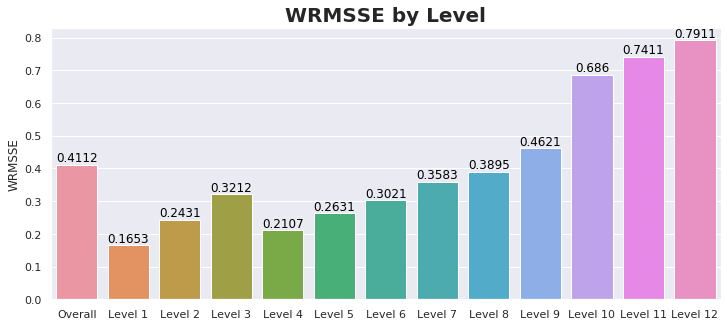

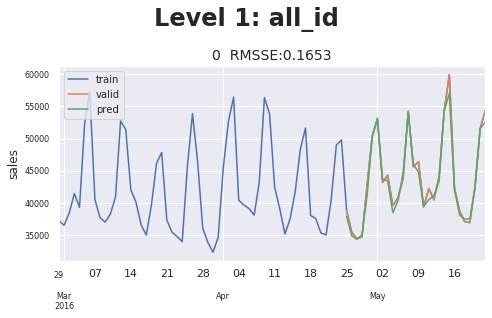

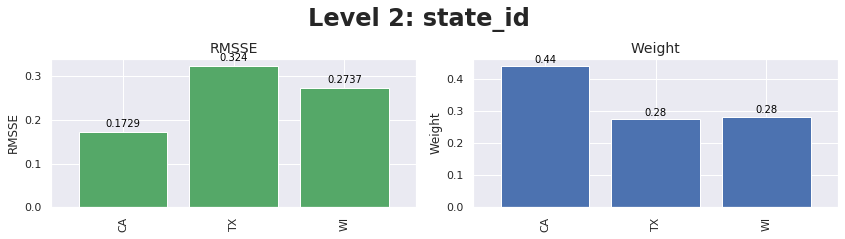

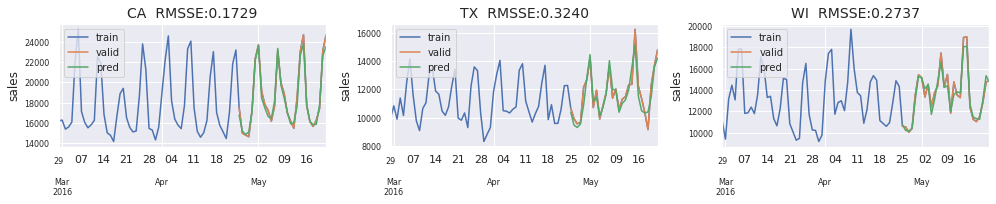

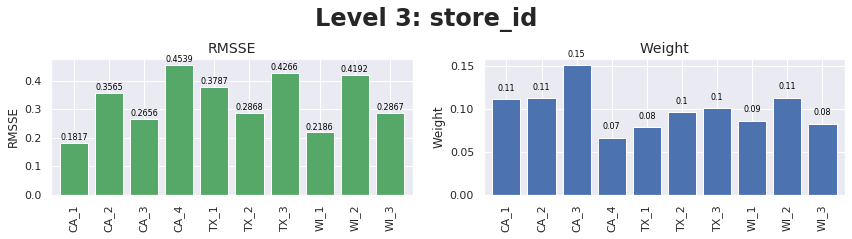

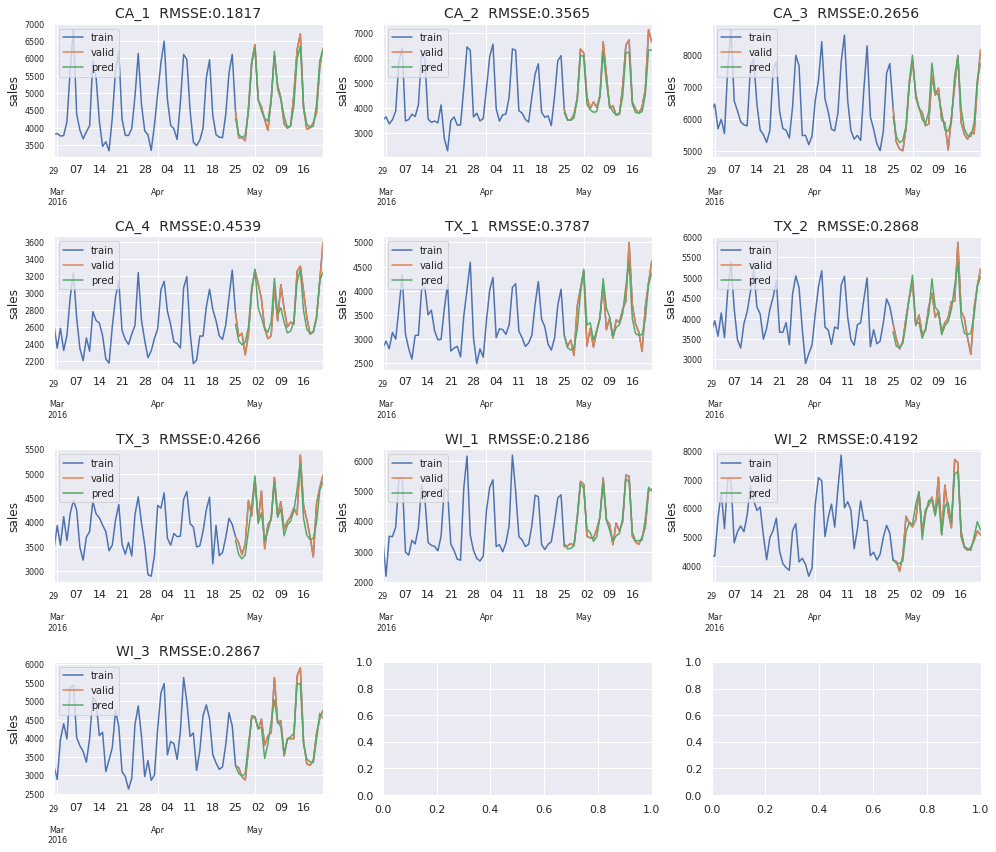

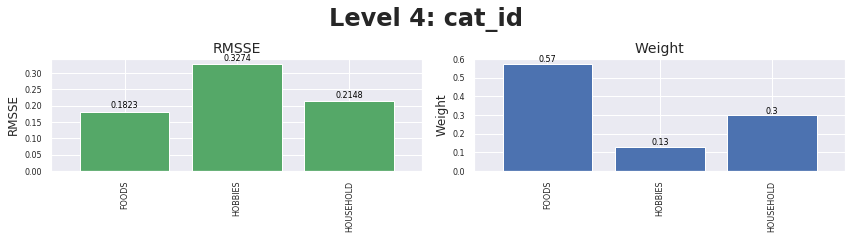

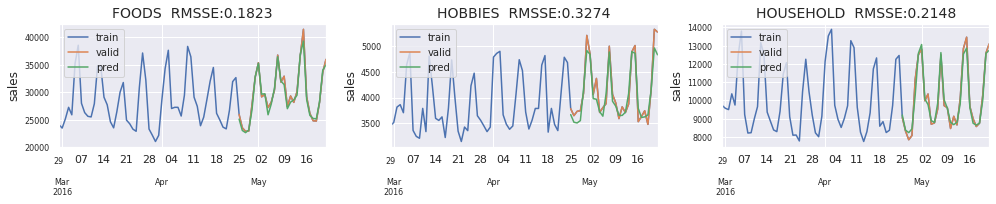

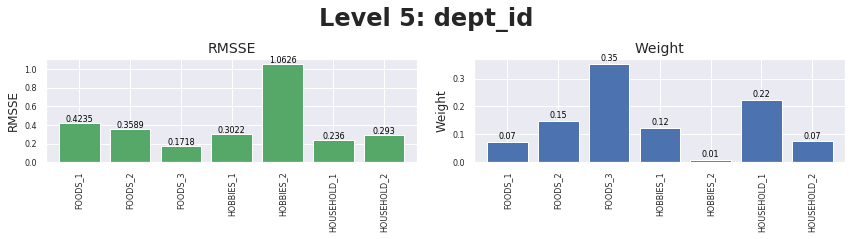

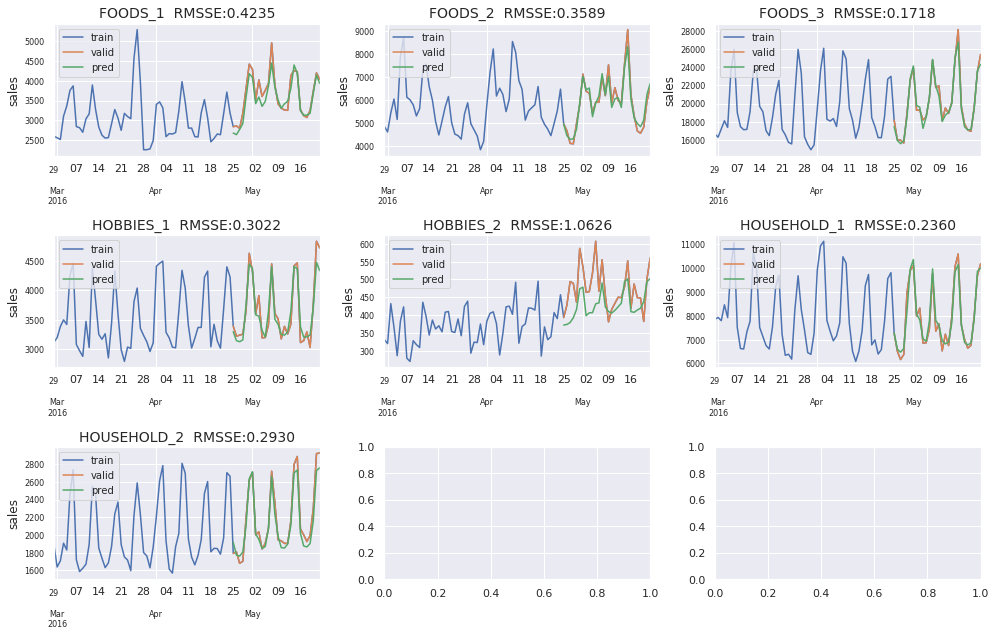

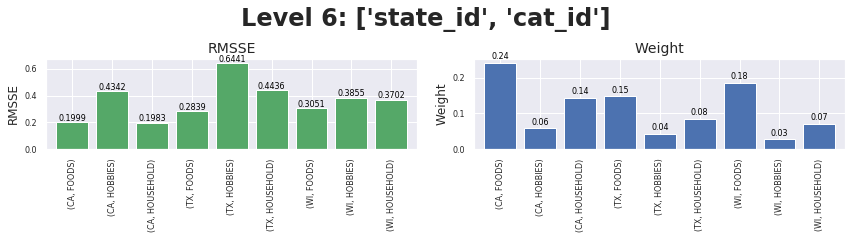

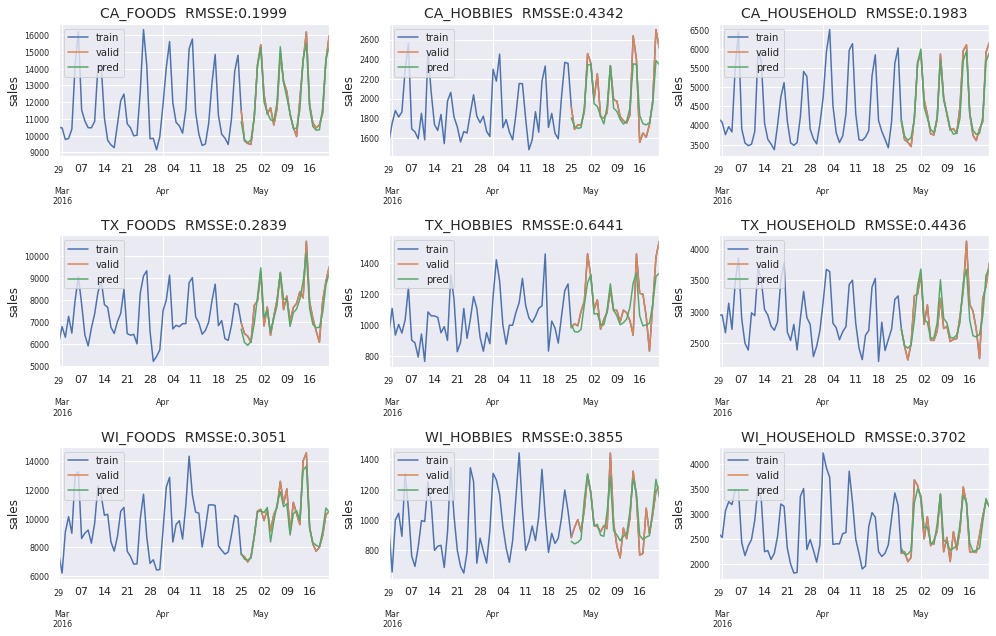

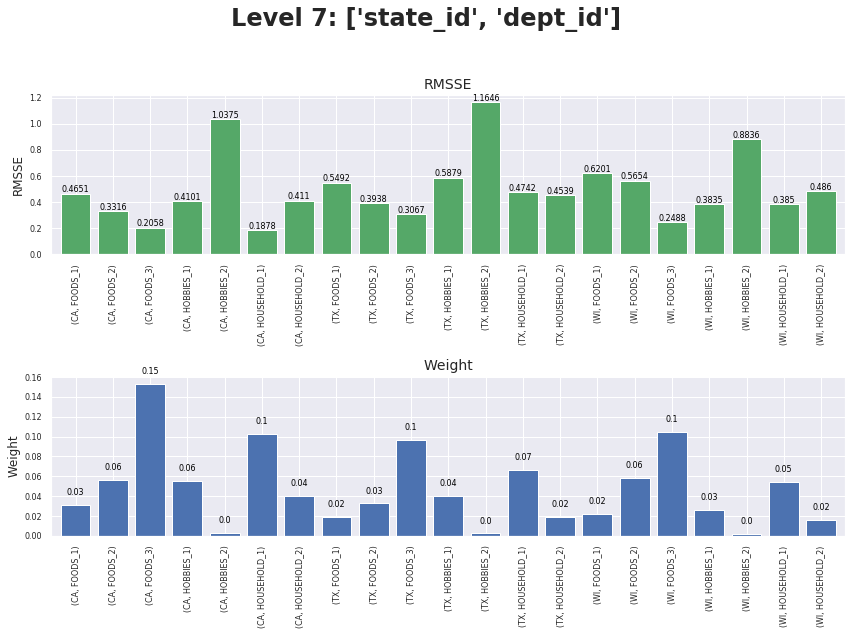

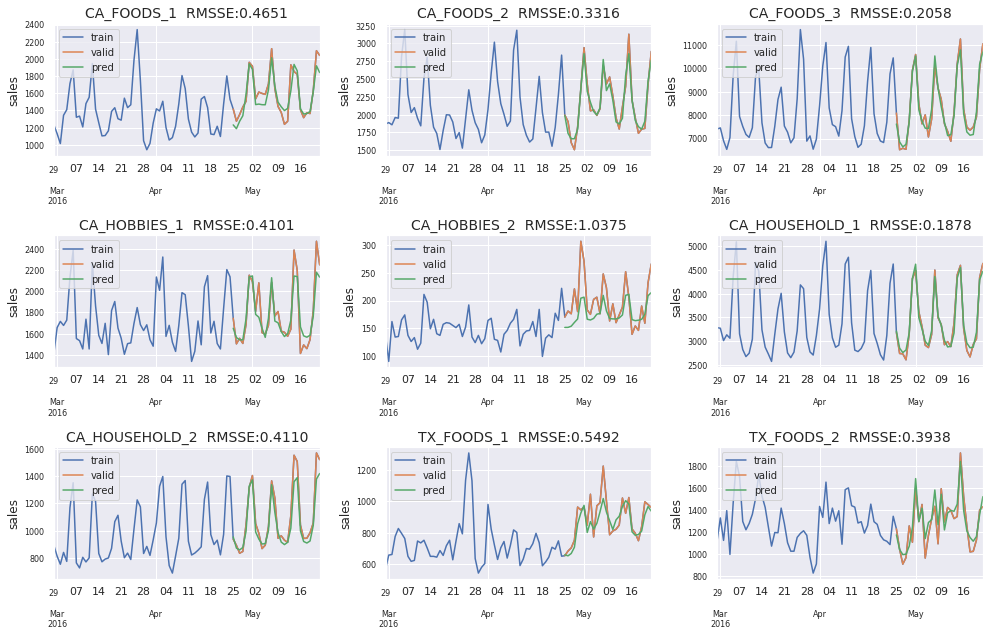

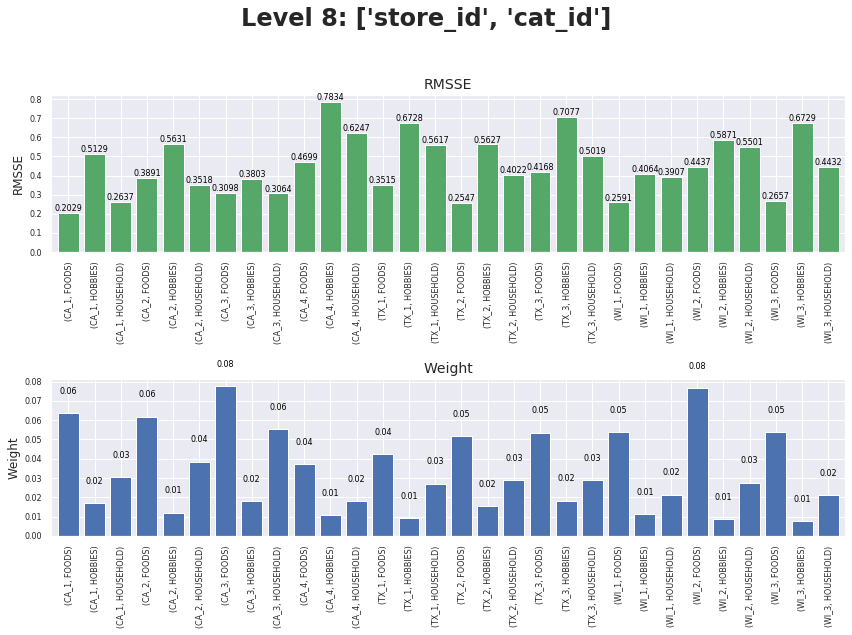

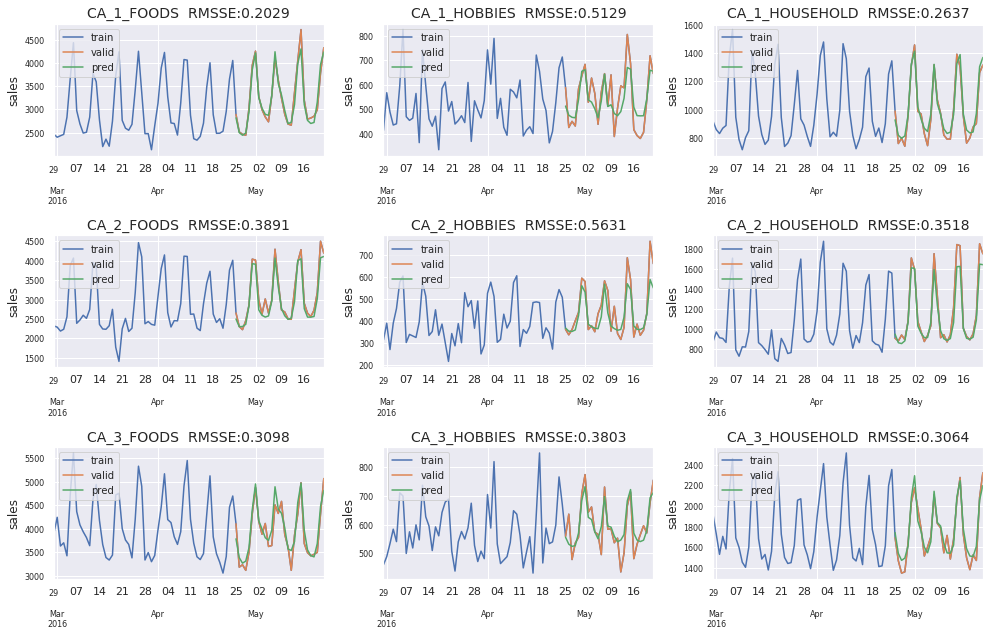

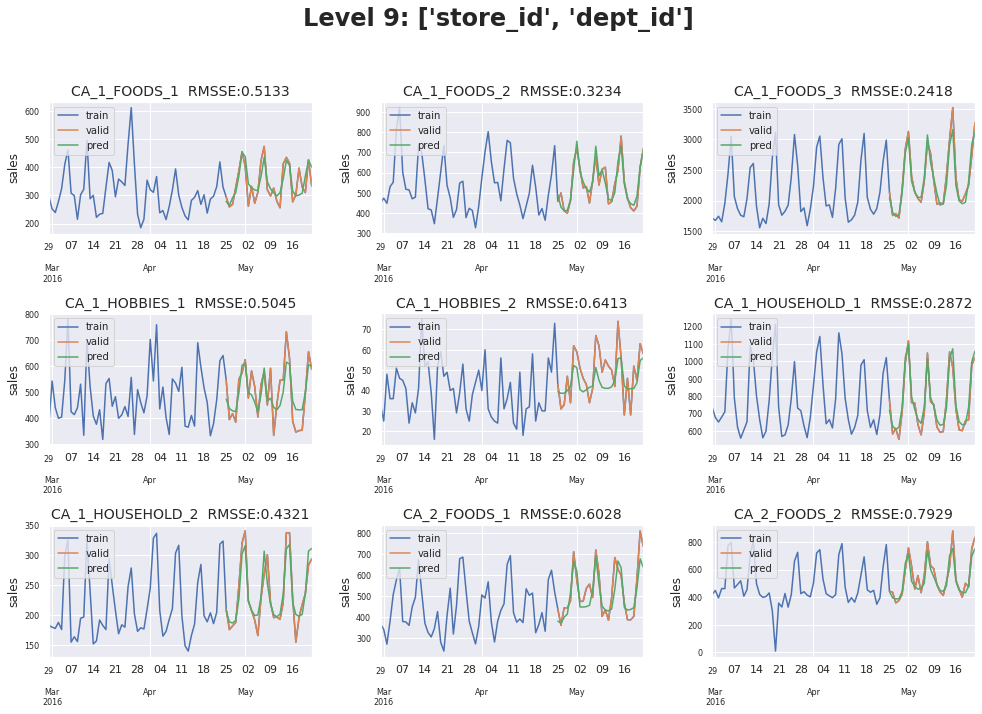

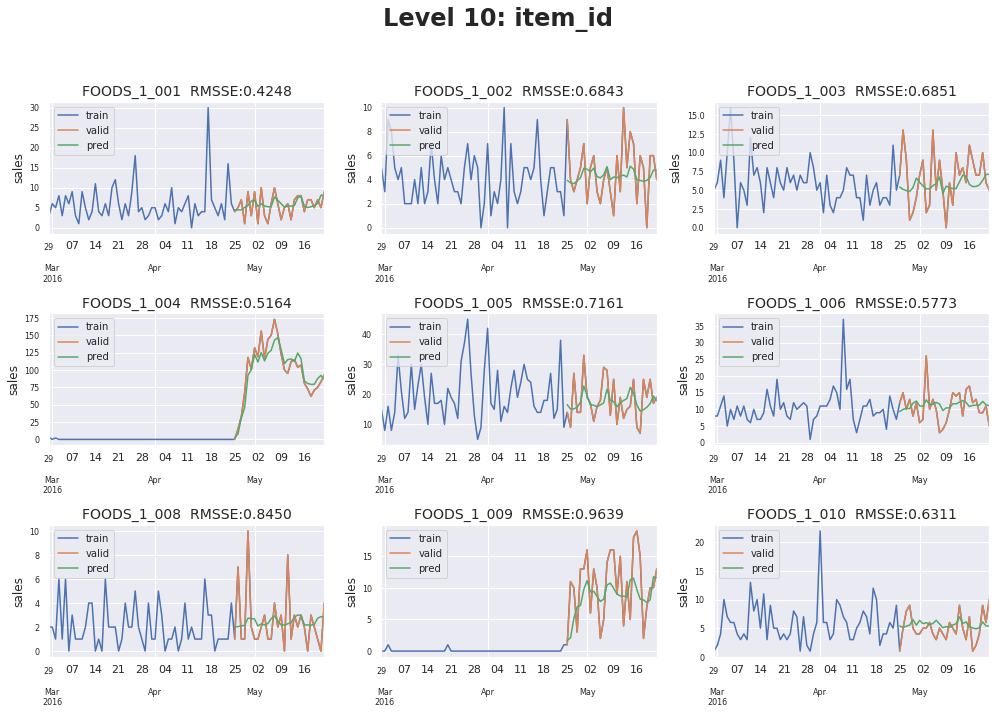

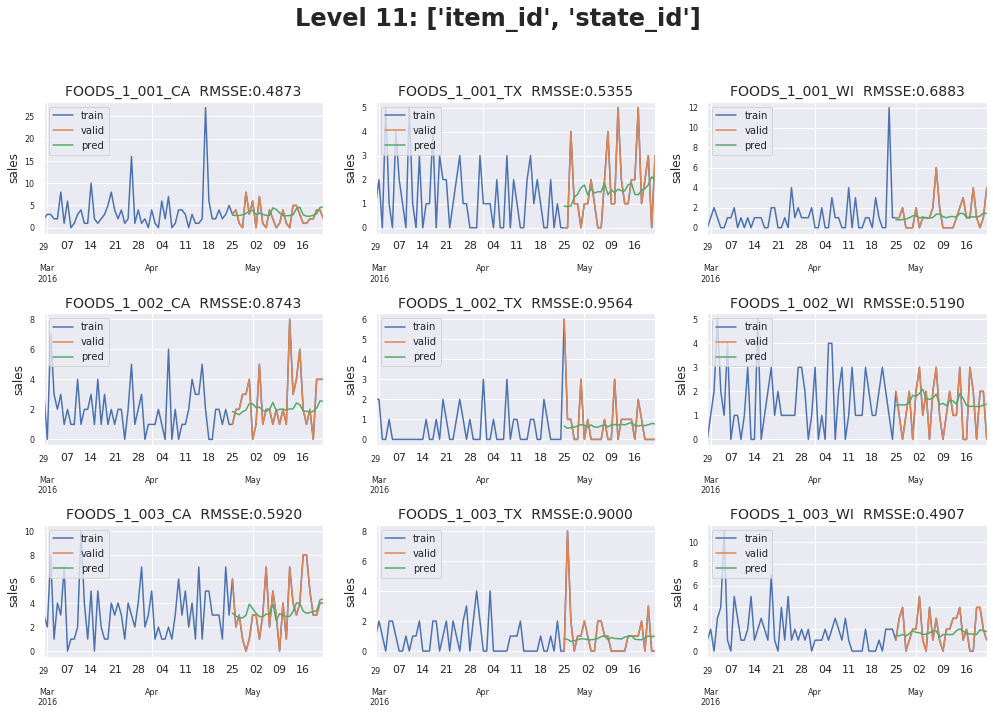

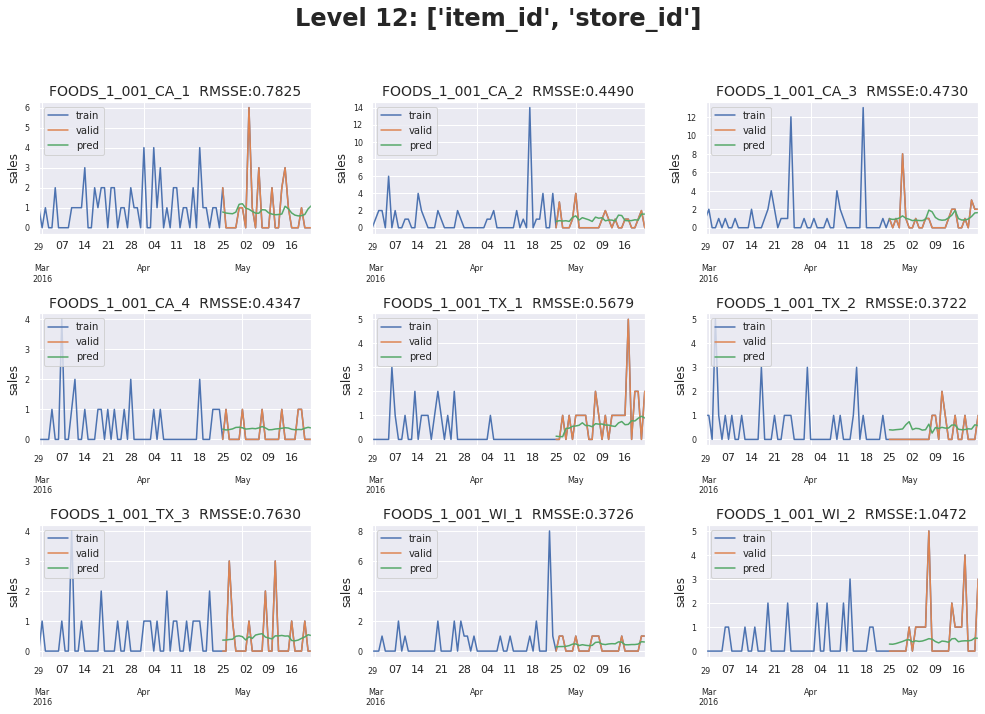

CPU times: user 8h 23min 33s, sys: 2min 12s, total: 8h 25min 46s
Wall time: 41min 39s


In [ ]:
%%time
final_preds = pd.DataFrame()
local_params = {
                'boosting_type': 'gbdt',                      
                'metric': 'None',           
                'subsample': 0.75,                
                'subsample_freq': 1,
                'learning_rate': 0.03,           
                'num_leaves': 2**10-1,            
                'min_data_in_leaf': 2**8-1,     
                'feature_fraction': 0.75,
                'n_estimators': 500,      
                'seed': SEED,
                'verbose': 0,
                'first_metric_only': True, # set this to true, if you want to use only the first metric for early stopping
                'force_row_wise': True, # not sure
#                     'use_missing': False,
#                     'max_bin': 2**8-1,
            } 

print('creating df...')
# FIRST_DAY = 475 here, 1942-1969 set null
df = create_dt(first_day=FIRST_DAY, is_cv=False)
# align complete blocks in the end of time series
df['t_block'] = df['d'].apply(lambda x: ceil((x+19)/(28))).astype(np.int8)
df = df[df['d'] <= END_TRAIN] # set END_TRAIN=1941 to get proper weights in WRMSSER
df = df[df['t_block'] > (df['t_block'].max() - TR_MONTHS - 3)].reset_index(drop=True)

print('creating WRMSSE evaluator...')
lgb_evaluators = get_evaluators(list(df['item_id'].unique()), 0)

print('creating general features...')
create_feat(df)
print('creating lags...')
create_lag_norm(df)

# remove those data only for creating lag features
df = df[df['t_block'] > (df['t_block'].max() - TR_MONTHS)].reset_index(drop=True)
print('train set period {}-{}'.format(df['d'].min(), df['d'].max()))
print('df shape: ', df.shape)

# item id is used in evaluation so it's not label encoded like other categories until now
df['item_id'] = df['item_id'].astype('category')
df['item_id'] = df['item_id'].cat.codes.astype('int16')
df['item_id'] -= df['item_id'].min()

# To be sure that some features are categoricals
catcols = ['item_id','dept_id','cat_id','store_id','state_id', 
         'event_name_1','event_type_1','event_name_2','event_type_2',]

# Our features
features_columns = [col for col in list(df) if col not in remove_features]
print('feature columns:')
print(features_columns)


valid_mask = df['t_block'] == df['t_block'].max()
# we add last block to train set
train_mask = (df['t_block'] <= df['t_block'].max()) & (df['wm_yr_wk'] >= df['release'])

print('Train time block', df[train_mask]['t_block'].min(), '-', df[train_mask]['t_block'].max(), df[train_mask]['d'].min(), df[train_mask]['d'].max())
print('Valid time block', ' '*4, df[valid_mask]['t_block'].max(), df[valid_mask]['d'].min(), df[valid_mask]['d'].max())
last_block_df = df[valid_mask]
X_train_np = df[train_mask][features_columns].values.astype('float32')
y_train_np = df[train_mask][TARGET].values.astype('float32')
X_valid_np = df[valid_mask][features_columns].values.astype('float32')
y_valid_np = df[valid_mask][TARGET].values.astype('float32')
# print('delete original df')
# del df; gc.collect()

train_data = lgb.Dataset(X_train_np, label=y_train_np, feature_name=features_columns, 
                         categorical_feature=catcols,)
valid_data = lgb.Dataset(X_valid_np, label=y_valid_np, feature_name=features_columns, 
                         categorical_feature=catcols)
# train_data = lgb.Dataset(X_train_np, label=y_train_np, feature_name=features_columns, 
#                          weights[train_mask].values.reshape(-1))
# valid_data = lgb.Dataset(X_valid_np, label=y_valid_np, feature_name=features_columns,)


local_params['objective'] = 'tweedie'             
local_params['tweedie_variance_power'] = 1.1  
seed_everything(SEED)
estimator = lgb.train(
                        local_params,
                        train_data,
                        valid_sets = [valid_data],
                        verbose_eval = 50,
                        feval = lambda preds, train_data: [lgb_evaluators.feval(preds,), 
                                          rmse(preds, train_data)], 
                        learning_rates = lambda iter: 0.03 * (0.999 ** iter),
                    ) 

# last fold
last_block_df['preds'] = estimator.predict(last_block_df[features_columns])
last_block_df = last_block_df[['id', 'd', TARGET, 'preds']]
score = lgb_evaluators.full_feval(last_block_df['preds'].values,)[1]
create_dashboard(lgb_evaluators)
del lgb_evaluators, train_data, valid_data; gc.collect()

with open(os.path.join(BASE_PATH, VER + 'final_model.pkl'), 'wb') as f:
    pickle.dump(estimator, f)

In [ ]:
# del df;gc.collect()

In [ ]:
# predict on valid&test set
print('creating test df...')
# FIRST_DAY-END_TRAIN
test = create_dt(is_train=False, is_cv=True, max_lags=500, tr_last=1941)
lgb_evaluator = get_evaluators(list(test['item_id'].unique()), 0, end=1941)
create_feat(test)
test['item_id'] = test['item_id'].astype('category')
test['item_id'] = test['item_id'].cat.codes.astype('int16')
test['item_id'] -= test['item_id'].min()

creating test df...


In [ ]:
test[~test.sales.isna()].tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,moon,sell_price,release,is_snap,week,quarter,mday,is_weekend,d_from_release,price_max,price_min,price_std,price_mean,price_norm,price_nunique,price_momentum_m,enc_item_id_store_id_mean,enc_item_id_store_id_std,enc_item_id_state_id_mean,enc_item_id_state_id_std,enc_state_id_cat_id_mean,enc_state_id_cat_id_std,enc_state_id_dept_id_mean,enc_state_id_dept_id_std,enc_store_id_cat_id_mean,enc_store_id_cat_id_std,enc_store_id_dept_id_mean,enc_store_id_dept_id_std
15275485,FOODS_3_823_WI_3_evaluation,3044,6,9,2,2,1941,1.0,2016-05-22,11617,3,2,5,5,0,0,0,0,4,2.98,11101,0,20,2,22,0,516,2.98,2.50,0.142356,2.849943,1.000000,3,1.017065,0.592814,0.913164,0.830339,1.192446,1.87144,4.596794,2.131773,5.333123,1.704741,4.763062,2.12408,5.888463
15275486,FOODS_3_824_WI_3_evaluation,3045,6,9,2,2,1941,0.0,2016-05-22,11617,3,2,5,5,0,0,0,0,4,2.48,11101,0,20,2,22,0,516,2.68,2.00,0.281568,2.191229,0.925373,3,1.107143,0.063872,0.576118,0.119095,0.545946,1.87144,4.596794,2.131773,5.333123,1.704741,4.763062,2.12408,5.888463
15275487,FOODS_3_825_WI_3_evaluation,3046,6,9,2,2,1941,2.0,2016-05-22,11617,3,2,5,5,0,0,0,0,4,3.98,11101,0,20,2,22,0,516,3.98,3.98,0.000000,3.980000,1.000000,1,1.000000,0.740519,1.008234,0.926813,1.195294,1.87144,4.596794,2.131773,5.333123,1.704741,4.763062,2.12408,5.888463
15275488,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,1941,0.0,2016-05-22,11617,3,2,5,5,0,0,0,0,4,1.28,11331,0,20,2,22,0,286,1.28,1.28,0.000000,1.280000,1.000000,1,1.000000,0.884232,1.399490,0.908184,1.457642,1.87144,4.596794,2.131773,5.333123,1.704741,4.763062,2.12408,5.888463
15275489,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,1941,1.0,2016-05-22,11617,3,2,5,5,0,0,0,0,4,1.00,11405,0,20,2,22,0,212,1.00,1.00,0.000000,1.000000,1.000000,1,1.000000,1.698603,1.966463,2.318031,2.830307,1.87144,4.596794,2.131773,5.333123,1.704741,4.763062,2.12408,5.888463


In [ ]:
block = 0
end = 1969
factor = 1
max_lag = 60
st = time.time()
for day_num in range(1, 29):
    print('predicting day{}'.format(day_num))
    inner_start = time.time()
    tmp = test.loc[(test.d <= end-28+day_num*1-28*block)&(test.d >= end-28-28*block-max_lag)].copy()
    tmp = pd.concat([tmp, df_parallelize_run(create_lag_test, LAGS_SPLIT)], axis=1)
    tmp = pd.concat([tmp, df_parallelize_run(create_lag_roll_test, ROLS_SPLIT)], axis=1)
    train_cols = tmp.columns[~tmp.columns.isin(remove_features)]
    tmp = tmp.loc[(tmp.d >= end-27+(day_num-1)*1-28*block), train_cols]
    test.loc[(test.d>=end-27+(day_num-1)*1-28*block)&(test.d<=end-28+day_num*1-28*block), 'sales'] = estimator.predict(tmp) * factor
    print('Time consumption:{}s'.format(time.time()-inner_start))
    del tmp
    gc.collect()
sub = test.loc[(test.d>=end-27-28*block)&(test.d<=end-28*block), ['id', 'd', 'sales']].copy()
with open(os.path.join(BASE_PATH, VER + '-block{}_recur.pkl'.format(i)), 'wb') as f:
    pickle.dump(sub, f)
del test
gc.collect()
print('prediction running time: ', np.round((time.time()-st)/60, 2))

predicting day1
Time consumption:37.9051308631897s
predicting day2
Time consumption:37.643800020217896s
predicting day3
Time consumption:38.04733657836914s
predicting day4
Time consumption:37.94230508804321s
predicting day5
Time consumption:38.19858121871948s
predicting day6
Time consumption:37.83222484588623s
predicting day7
Time consumption:38.03445649147034s
predicting day8
Time consumption:38.186177253723145s
predicting day9
Time consumption:38.25579309463501s
predicting day10
Time consumption:38.59543800354004s
predicting day11
Time consumption:38.2837860584259s
predicting day12
Time consumption:38.29101490974426s
predicting day13
Time consumption:38.380454540252686s
predicting day14
Time consumption:38.834567070007324s
predicting day15
Time consumption:38.8307466506958s
predicting day16
Time consumption:39.257534980773926s
predicting day17
Time consumption:39.173980474472046s
predicting day18
Time consumption:39.585349798202515s
predicting day19
Time consumption:39.3720440864563s

NameError: name 'ed' is not defined

In [ ]:
# formatting submission
final_sub = pd.read_csv(BASE_PATH + "sample_submission.csv",)
evaluation_df = pd.pivot(sub, index = 'id', columns = 'd', values = 'sales').reset_index()
evaluation_df.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation_df.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.787300,0.674389,0.667586,0.647722,0.653112,0.952209,0.997622,0.653034,0.688177,0.805381,0.819263,1.004152,1.025395,1.008628,0.814012,0.693394,0.792228,0.770990,0.811768,1.113436,1.149075,0.848122,0.698763,0.678587,0.707569,0.733606,0.926691,1.038051
1,FOODS_1_001_CA_2_evaluation,0.857479,0.866309,0.836704,0.865900,0.826649,1.460108,1.446896,0.908372,0.758687,0.952266,0.993961,1.116500,1.604783,1.376110,0.946906,0.842118,0.934332,0.948953,0.933519,1.343237,1.224711,0.849329,0.856576,0.857139,0.889546,0.957439,1.341236,1.273534
2,FOODS_1_001_CA_3_evaluation,0.875380,0.854194,0.899232,0.968685,1.284896,1.557162,1.764107,1.107590,0.902317,0.987330,1.116053,1.656420,1.811691,1.771560,1.110623,0.920458,1.016667,1.064255,1.310416,1.429705,1.646809,0.973549,0.891814,0.977993,1.024475,1.239691,1.521617,1.758725
3,FOODS_1_001_CA_4_evaluation,0.336607,0.336368,0.342098,0.362471,0.404733,0.377521,0.383900,0.287500,0.298775,0.326907,0.331932,0.390835,0.405396,0.353004,0.310521,0.270187,0.297941,0.308592,0.341108,0.376281,0.361862,0.302725,0.287325,0.307460,0.347313,0.361194,0.370482,0.331755
4,FOODS_1_001_TX_1_evaluation,0.799585,0.936317,0.748366,0.804969,0.774074,0.821327,0.836654,0.688926,0.717594,0.808285,0.817512,0.953182,1.018676,1.048338,0.906430,0.745134,0.784921,0.869741,0.731645,1.043392,1.097296,0.854146,0.811019,0.843841,0.864554,0.803491,1.163077,1.299753


In [ ]:
 pd.pivot(sub, index = 'id', columns = 'd', values = 'sales').reset_index()

d,id,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969
0,FOODS_1_001_CA_1_evaluation,0.787300,0.674389,0.667586,0.647722,0.653112,0.952209,0.997622,0.653034,0.688177,0.805381,0.819263,1.004152,1.025395,1.008628,0.814012,0.693394,0.792228,0.770990,0.811768,1.113436,1.149075,0.848122,0.698763,0.678587,0.707569,0.733606,0.926691,1.038051
1,FOODS_1_001_CA_2_evaluation,0.857479,0.866309,0.836704,0.865900,0.826649,1.460108,1.446896,0.908372,0.758687,0.952266,0.993961,1.116500,1.604783,1.376110,0.946906,0.842118,0.934332,0.948953,0.933519,1.343237,1.224711,0.849329,0.856576,0.857139,0.889546,0.957439,1.341236,1.273534
2,FOODS_1_001_CA_3_evaluation,0.875380,0.854194,0.899232,0.968685,1.284896,1.557162,1.764107,1.107590,0.902317,0.987330,1.116053,1.656420,1.811691,1.771560,1.110623,0.920458,1.016667,1.064255,1.310416,1.429705,1.646809,0.973549,0.891814,0.977993,1.024475,1.239691,1.521617,1.758725
3,FOODS_1_001_CA_4_evaluation,0.336607,0.336368,0.342098,0.362471,0.404733,0.377521,0.383900,0.287500,0.298775,0.326907,0.331932,0.390835,0.405396,0.353004,0.310521,0.270187,0.297941,0.308592,0.341108,0.376281,0.361862,0.302725,0.287325,0.307460,0.347313,0.361194,0.370482,0.331755
4,FOODS_1_001_TX_1_evaluation,0.799585,0.936317,0.748366,0.804969,0.774074,0.821327,0.836654,0.688926,0.717594,0.808285,0.817512,0.953182,1.018676,1.048338,0.906430,0.745134,0.784921,0.869741,0.731645,1.043392,1.097296,0.854146,0.811019,0.843841,0.864554,0.803491,1.163077,1.299753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.270742,0.259531,0.268796,0.271298,0.331789,0.364542,0.356687,0.274108,0.232824,0.222149,0.222522,0.268381,0.353675,0.319926,0.207420,0.212627,0.218341,0.219972,0.281311,0.343034,0.317252,0.214700,0.213585,0.206054,0.224240,0.287512,0.347996,0.326290
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.172320,0.158160,0.159884,0.176664,0.191366,0.236794,0.213831,0.177391,0.156714,0.162285,0.177033,0.206007,0.252389,0.283183,0.187323,0.179842,0.182546,0.195273,0.226516,0.308206,0.274328,0.186140,0.185583,0.184160,0.199377,0.235261,0.313801,0.284298
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.075479,0.074262,0.074068,0.082743,0.093714,0.111026,0.103789,0.081517,0.076082,0.075841,0.074695,0.092895,0.126951,0.122467,0.086179,0.091077,0.084501,0.082711,0.098758,0.122270,0.115193,0.084538,0.080279,0.079591,0.085225,0.105809,0.119915,0.107309
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.062034,0.061314,0.060637,0.062596,0.070180,0.078596,0.074194,0.063047,0.063249,0.063775,0.060627,0.069524,0.077998,0.073835,0.058492,0.060270,0.057987,0.059394,0.067794,0.079889,0.075362,0.067552,0.066241,0.064625,0.065080,0.075297,0.089584,0.081769


In [ ]:
validation_df = pd.pivot(last_block_df, index = 'id', columns = 'd', values = 'preds').reset_index()
validation_df.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
validation_df['id'] = validation_df['id'].apply(lambda x:x[:-10]) + 'validation'
validation_df.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.785004,0.734572,0.713329,0.698644,0.781009,1.169562,1.197257,0.979017,0.923912,0.817357,0.728024,0.724291,0.900901,0.885601,0.742122,0.680606,0.649029,0.661209,0.683033,1.071999,0.945116,0.737539,0.628660,0.592109,0.602349,0.662021,0.940405,1.101319
1,FOODS_1_001_CA_2_validation,0.725081,0.824138,0.778139,0.816961,0.732642,1.205636,1.384623,0.892952,1.171840,1.045637,0.918307,0.733440,1.235607,1.110235,1.166117,0.805731,0.898195,0.888260,0.789055,1.465718,1.420640,0.837735,0.813685,0.834653,0.924409,0.888152,1.581779,1.589839
2,FOODS_1_001_CA_3_validation,0.961904,0.899256,0.931972,1.052290,1.282931,1.021031,0.920928,0.769162,0.826656,0.781344,0.771613,0.913962,1.904302,1.724431,1.108942,0.883468,0.812606,0.845459,1.070515,1.358265,1.868191,0.994872,0.835275,0.838478,0.942477,1.212715,1.601161,1.634298
3,FOODS_1_001_CA_4_validation,0.340938,0.314313,0.326793,0.350081,0.399233,0.405030,0.386832,0.344222,0.353648,0.366499,0.356504,0.382458,0.428704,0.382332,0.320511,0.324680,0.346149,0.356137,0.371582,0.388535,0.378597,0.337088,0.321697,0.330818,0.327700,0.371903,0.402285,0.381091
4,FOODS_1_001_TX_1_validation,0.133904,0.117806,0.113414,0.452157,0.468679,0.545919,0.559314,0.588695,0.691384,0.576751,0.576023,0.527631,0.654704,0.636220,0.640805,0.596920,0.594815,0.561619,0.538328,0.684541,0.745099,0.612086,0.625489,0.780685,0.767162,0.879336,0.965460,0.891526


In [ ]:
pd.pivot(last_block_df, index = 'id', columns = 'd', values = 'preds').reset_index()

d,id,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941
0,FOODS_1_001_CA_1_evaluation,0.785004,0.734572,0.713329,0.698644,0.781009,1.169562,1.197257,0.979017,0.923912,0.817357,0.728024,0.724291,0.900901,0.885601,0.742122,0.680606,0.649029,0.661209,0.683033,1.071999,0.945116,0.737539,0.628660,0.592109,0.602349,0.662021,0.940405,1.101319
1,FOODS_1_001_CA_2_evaluation,0.725081,0.824138,0.778139,0.816961,0.732642,1.205636,1.384623,0.892952,1.171840,1.045637,0.918307,0.733440,1.235607,1.110235,1.166117,0.805731,0.898195,0.888260,0.789055,1.465718,1.420640,0.837735,0.813685,0.834653,0.924409,0.888152,1.581779,1.589839
2,FOODS_1_001_CA_3_evaluation,0.961904,0.899256,0.931972,1.052290,1.282931,1.021031,0.920928,0.769162,0.826656,0.781344,0.771613,0.913962,1.904302,1.724431,1.108942,0.883468,0.812606,0.845459,1.070515,1.358265,1.868191,0.994872,0.835275,0.838478,0.942477,1.212715,1.601161,1.634298
3,FOODS_1_001_CA_4_evaluation,0.340938,0.314313,0.326793,0.350081,0.399233,0.405030,0.386832,0.344222,0.353648,0.366499,0.356504,0.382458,0.428704,0.382332,0.320511,0.324680,0.346149,0.356137,0.371582,0.388535,0.378597,0.337088,0.321697,0.330818,0.327700,0.371903,0.402285,0.381091
4,FOODS_1_001_TX_1_evaluation,0.133904,0.117806,0.113414,0.452157,0.468679,0.545919,0.559314,0.588695,0.691384,0.576751,0.576023,0.527631,0.654704,0.636220,0.640805,0.596920,0.594815,0.561619,0.538328,0.684541,0.745099,0.612086,0.625489,0.780685,0.767162,0.879336,0.965460,0.891526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.265495,0.257767,0.269644,0.260850,0.309088,0.377618,0.336788,0.224383,0.227928,0.237199,0.253378,0.284817,0.355448,0.327452,0.247859,0.250371,0.239850,0.240657,0.288819,0.360844,0.327008,0.246646,0.250952,0.262897,0.273992,0.337825,0.399977,0.357510
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.144031,0.145007,0.153801,0.161508,0.173936,0.182221,0.197127,0.146154,0.141856,0.140458,0.162015,0.169354,0.226175,0.205337,0.162509,0.161071,0.157772,0.174436,0.184708,0.228143,0.211544,0.155374,0.145936,0.148962,0.175560,0.194584,0.240283,0.237114
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.079343,0.070317,0.070084,0.069993,0.086630,0.101217,0.101418,0.068343,0.066536,0.067586,0.071443,0.099850,0.118206,0.089852,0.072561,0.068937,0.068247,0.069208,0.087383,0.104430,0.103353,0.079213,0.078831,0.079408,0.079839,0.095166,0.122626,0.116868
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.048937,0.049468,0.048650,0.049017,0.054627,0.056885,0.055267,0.046863,0.046601,0.046587,0.047494,0.049960,0.054958,0.046903,0.044290,0.044239,0.045342,0.045172,0.049927,0.054389,0.048979,0.047349,0.051049,0.050944,0.052400,0.056236,0.061960,0.058817


In [ ]:
sub_total = pd.concat([validation_df, evaluation_df])
sub_total

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.785004,0.734572,0.713329,0.698644,0.781009,1.169562,1.197257,0.979017,0.923912,0.817357,0.728024,0.724291,0.900901,0.885601,0.742122,0.680606,0.649029,0.661209,0.683033,1.071999,0.945116,0.737539,0.628660,0.592109,0.602349,0.662021,0.940405,1.101319
1,FOODS_1_001_CA_2_validation,0.725081,0.824138,0.778139,0.816961,0.732642,1.205636,1.384623,0.892952,1.171840,1.045637,0.918307,0.733440,1.235607,1.110235,1.166117,0.805731,0.898195,0.888260,0.789055,1.465718,1.420640,0.837735,0.813685,0.834653,0.924409,0.888152,1.581779,1.589839
2,FOODS_1_001_CA_3_validation,0.961904,0.899256,0.931972,1.052290,1.282931,1.021031,0.920928,0.769162,0.826656,0.781344,0.771613,0.913962,1.904302,1.724431,1.108942,0.883468,0.812606,0.845459,1.070515,1.358265,1.868191,0.994872,0.835275,0.838478,0.942477,1.212715,1.601161,1.634298
3,FOODS_1_001_CA_4_validation,0.340938,0.314313,0.326793,0.350081,0.399233,0.405030,0.386832,0.344222,0.353648,0.366499,0.356504,0.382458,0.428704,0.382332,0.320511,0.324680,0.346149,0.356137,0.371582,0.388535,0.378597,0.337088,0.321697,0.330818,0.327700,0.371903,0.402285,0.381091
4,FOODS_1_001_TX_1_validation,0.133904,0.117806,0.113414,0.452157,0.468679,0.545919,0.559314,0.588695,0.691384,0.576751,0.576023,0.527631,0.654704,0.636220,0.640805,0.596920,0.594815,0.561619,0.538328,0.684541,0.745099,0.612086,0.625489,0.780685,0.767162,0.879336,0.965460,0.891526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.270742,0.259531,0.268796,0.271298,0.331789,0.364542,0.356687,0.274108,0.232824,0.222149,0.222522,0.268381,0.353675,0.319926,0.207420,0.212627,0.218341,0.219972,0.281311,0.343034,0.317252,0.214700,0.213585,0.206054,0.224240,0.287512,0.347996,0.326290
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.172320,0.158160,0.159884,0.176664,0.191366,0.236794,0.213831,0.177391,0.156714,0.162285,0.177033,0.206007,0.252389,0.283183,0.187323,0.179842,0.182546,0.195273,0.226516,0.308206,0.274328,0.186140,0.185583,0.184160,0.199377,0.235261,0.313801,0.284298
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.075479,0.074262,0.074068,0.082743,0.093714,0.111026,0.103789,0.081517,0.076082,0.075841,0.074695,0.092895,0.126951,0.122467,0.086179,0.091077,0.084501,0.082711,0.098758,0.122270,0.115193,0.084538,0.080279,0.079591,0.085225,0.105809,0.119915,0.107309
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.062034,0.061314,0.060637,0.062596,0.070180,0.078596,0.074194,0.063047,0.063249,0.063775,0.060627,0.069524,0.077998,0.073835,0.058492,0.060270,0.057987,0.059394,0.067794,0.079889,0.075362,0.067552,0.066241,0.064625,0.065080,0.075297,0.089584,0.081769


In [ ]:
final_sub = final_sub[['id']].merge(sub_total, on='id')
final_sub.to_csv('./output/final_sub_0629.csv', index=False)

In [ ]:
final_sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.916289,0.833298,0.843754,0.833378,0.969978,1.285754,1.085772,0.631964,0.579899,0.578793,0.566365,0.620384,0.960932,0.842158,0.952967,0.868071,0.818101,0.794684,0.887467,1.386948,1.161227,0.849116,0.724466,0.753282,0.808806,0.796958,1.098313,1.184660
1,HOBBIES_1_002_CA_1_validation,0.198861,0.183313,0.196629,0.179990,0.231144,0.277384,0.295876,0.189997,0.201244,0.176683,0.189982,0.209887,0.249859,0.202625,0.170887,0.172001,0.167866,0.150473,0.179700,0.226218,0.259408,0.208758,0.223141,0.228939,0.226543,0.256614,0.320119,0.331577
2,HOBBIES_1_003_CA_1_validation,0.384496,0.335165,0.353399,0.381362,0.578299,0.707108,0.725394,0.423273,0.389998,0.392305,0.411812,0.625713,0.862981,0.828157,0.590493,0.545482,0.567298,0.672227,0.940249,0.936536,0.897772,0.543584,0.464799,0.471005,0.486897,0.867107,1.154022,1.120500
3,HOBBIES_1_004_CA_1_validation,1.719253,1.475227,1.429238,1.481985,1.870472,2.774389,3.804191,1.714770,1.633286,1.484480,1.499382,1.748396,2.917116,2.455026,1.773055,1.541749,1.604094,1.613181,1.984437,3.150804,3.705724,1.860784,1.577182,1.487392,1.488994,1.725930,3.147675,3.098917
4,HOBBIES_1_005_CA_1_validation,1.133039,0.987127,0.995276,1.110860,1.258836,1.558706,1.740776,1.226185,1.189025,1.212351,1.230554,1.288626,1.733067,1.414976,1.345183,1.226650,1.240784,1.324674,1.497535,1.802946,1.802237,1.260890,1.123848,1.133933,1.142629,1.166891,1.661680,1.717555
